In [1]:
import numpy as np; np.random.seed(1218042)
import seaborn as sb; sb.set()
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook as tqdm 

# Population Model of Competition between cancer and T cells

Let $f_{C}(t, u)$ and $f_{I}(t, u)$ model the local densities of cancer and T cells. Then their growths are determined by:

$$
\frac{\delta}{\delta t}f_{C}(t, u) = R_{C}(t, u)f_{C}(t, u)
$$
$$
\frac{\delta}{\delta t}f_{I}(t, v) = R_{I}(t, v)f_{I}(t, v)
$$

where $R_{C}$ and $R_{I}$ model the net proliferation rates of cancer cells and T cells, respectively:

$$
R_{C}(t, v) := (\kappa_{C} - \mu_{C}\rho_{C}(t)) - \int_{V} \eta_{\theta_{I}}(|u-v|)f_{I}(t, v)dv
$$
$$
R_{I}(t, v) := [\int_{U}\eta_{\theta_{E}}(|u-v|)f_{C}(t, u)du + \kappa_{P}c_{P}(t)] - \frac{\mu_{I}}{1+\mu_{M}c_{M}(t)}\rho_{I}(t)
$$

The implementation is as follows:

### $\kappa_{C, P}$ the natural growth rate of each cell type.

In [2]:
kappa_C = 1
kappa_P = 1

### $\mu_{C, I, M}$ the natural death rate of each cell type.

In [3]:
mu_C = 0.5
mu_I = 0.5
mu_M = 1

### $c_{P, M}$ the immune proliferation boosters.

In [4]:
c_P = lambda t: 0
c_M = lambda t: 0

### $f_{C}(t, u)$ and $f_{I}(t, v)$ local densities of cancer or T cells.

In [5]:
f_C = lambda u: np.exp(-np.square(u-0.5)/(0.001))
f_I = lambda v: (np.exp(v)-1)/v - 1

### $\rho_{C}(t) = \int_{U}f_{C}(t, u)du$ and $\rho_{I}(t) = \int_{V}f_{I}(t, v)dv$ the global densities of cells.

In [6]:
rho_C = lambda _f_C: sum(_f_C)
rho_I = lambda _f_I: sum(_f_I)

### $\theta_{E, I}$ the interaction selectivity parameters and $\eta_{\theta_{E}, \theta_{I}}$ the interaction rates.

In [7]:
theta_E = 1000 # leading to clonal expansion
theta_I = 1000 # leading to cancer death

# The interaction rates that lead to cancer cell death (<-> rider waiting time)
eta_theta_E = lambda u,v: np.exp(-theta_E*np.square(np.abs(u-v)))
# The interaction rates that lead to clonal expansion (<-> driver idle time)
eta_theta_I = lambda u,v: np.exp(-theta_I*np.square(np.abs(u-v)))

###  $R_{C, I}$ the proliferation rates.

In [8]:
R_C = lambda V,u,_f_C: (kappa_C - mu_C*rho_C(_f_C)) - sum([eta_theta_I(u, v) * v for v in V])
R_I = lambda U,v,_f_I: (sum([eta_theta_E(u, v) * u for u in U])  + kappa_C*c_P) - mu_I/(1 + mu_M*c_M * rho_I(_f_I))

## Modelling the growth

To recreate the model, $f_{C,I}$ will be an array of its values where each index reprents its value at time $t$.

At every time step ($\Delta t = 0.1$):

$$f_{C}(t_{k+1}, u) = f_{C}(t_{k}, u) + \Delta t [R^{+}_{C}(t_{k}, u)f_{C}(t_{k}, u) - R^{-}_{C}(t_{k}, u)f_{C}(t_{k+1}, u)]$$
$$f_{I}(t_{k+1}, v) = f_{I}(t_{k}, v) + \Delta t [R^{+}_{I}(t_{k}, v)f_{I}(t_{k}, v) - R^{-}_{I}(t_{k}, v)f_{I}(t_{k+1}, v)]$$

or in explicit terms:

$$f_{C}(t_{k+1}, u) = f_{C}(t_{k}, u) \frac{1+\Delta t R^{+}_{C}(t_{k}, u)}{1+\Delta t R^{-}_{C}(t_{k}, u)} \qquad f_{I}(t_{k+1}, v) = f_{I}(t_{k}, v) \frac{1+\Delta t R^{+}_{I}(t_{k}, v)}{1+\Delta t R^{-}_{I}(t_{k}, v)}$$

We will compute this evolution for all possible starting values of $u$ and $v$.

In [21]:
def simulate_growth(N=100, t=121, delta_T=0.1,
                    kappa_C=1, kappa_P=1,
                    mu_C=0.5, mu_I=0.5, mu_M=1,
                    c_P=lambda t: 0, c_M=lambda t: 0,
                    f_C=lambda u: np.exp(-np.square(u-0.5)/(0.001))/17.841245033443414,
                    f_I=lambda v: 1,
                    theta_E=1000, theta_I=1000):
    
    eta_theta_E = lambda u,v: np.exp(-theta_E*np.square(np.abs(u-v)))
    eta_theta_I = lambda u,v: np.exp(-theta_I*np.square(np.abs(u-v)))
    
    R_C = lambda _f_C,u,_f_I: (kappa_C - mu_C*rho_C(_f_C*1/N)) - sum([eta_theta_I(u, v) * v * 1/N for v in _f_I])
    R_I = lambda _f_I,v,_f_C, t: (sum([eta_theta_E(u, v) * u * 1/N for u in _f_C])  + kappa_C*c_P(t)) - mu_I/(1 + mu_M*c_M(t) * rho_I(_f_I*1/N))
    
    # Initial values of cancer and T cells
    initial_values = np.linspace(0, 1, num=N)
    
    # Apply the growth equation for each time step
    for i in tqdm(range(int(t/delta_T))):
        
        if i == 0:
            cancer = np.array([[f_C(u) for u in initial_values]])
            immune = np.array([[f_I(v) for v in initial_values]])
            continue
        
        # Get f_*[t]
        _f_C = cancer[-1]
        _f_I = immune[-1]

        # Compute the increments
        _R_C = [R_C(_f_C, u, _f_I) for u in _f_C]
        _R_I = [R_I(_f_I, v, _f_C, i*delta_T) for v in _f_I]
        
        # Get the positive and negative parts of _R_*
        p_R_C, n_R_C = split_positive_negative(_R_C)
        p_R_I, n_R_I = split_positive_negative(_R_I)
        
        # Compute f_*[t+1]
        new_f_C = _f_C * (1 + delta_T*p_R_C) / (1 + delta_T*n_R_C)
        new_f_I = _f_I * (1 + delta_T*p_R_I) / (1 + delta_T*n_R_I)
        
        # Aggregate the results
        cancer = np.concatenate((cancer, [new_f_C.clip(min=0)]))
        immune = np.concatenate((immune, [new_f_I.clip(min=0)]))
        
        print(f"Cancer: {np.mean(cancer)}")
        print(f"Immune: {np.mean(immune)}", end="\n\n")
        if np.isnan(cancer.min()) or np.isnan(cancer.max()):
            return cancer[:-1], immune[:-1], initial_values, i*delta_T
    
    return cancer, immune, initial_values, t

def split_positive_negative(values):
    """ Splits the input list into a list of its positives and negatives """
    positive, negative = [], []
    for v in values:
        p, n = (0, 0) if v == 0 else ((1, 0) if v > 0 else (0, 1))
        positive.append(v if p else 0)
        negative.append(v if n else 0)
    return np.array(positive), np.array(negative)

def plot_growth_surface(cancer, immune, initial_values, t=121):
    
    # Create a mesh-grid for printing
    initial_values, time = np.meshgrid(initial_values, np.linspace(0, 121, num=len(cancer)))
    fig = plt.figure(figsize=(24, 8))

    #===============
    #  Cancer growth
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    # Plot the surface
    ax.plot_surface(time, initial_values, cancer)

    # Set labels and title
    ax.set_xlabel('t', size=12)
    ax.set_ylabel('u', size=12)
    ax.set_zlabel('f_C(t, u)', size=12)
    plt.tight_layout()
    plt.title(f'Growth of cancer cells', size=15)

    #===============
    # Immune growth
    #===============
    # set up the axes for the second plot
    ax = fig.add_subplot(1, 2, 2, projection='3d')

    # Plot the surface
    ax.plot_surface(time, initial_values, immune)

    # Set labels and title
    ax.set_xlabel('t', size=12)
    ax.set_ylabel('v', size=12)
    ax.set_zlabel('f_I(t, v)', size=12)
    plt.tight_layout()
    plt.title(f'Growth of immune cells', size=15)

    # Show entire figure
    plt.show()
    
def plot_growth_cmap(cancer, immune, initial_values, t=121):

    fig = plt.figure(figsize=(12, 8))
    time = np.linspace(0, t, num=len(cancer))
    # Setup the tick marks (for time and initial values)
    xticks = [i if i in [0, 0.5, 1] else '' for i in initial_values]
    marks = [0, 200, 400, 600, 800, 1000, 1200]
    yticks = [int(t) if i in marks else '' for i,t in enumerate(time)][::-1]

    #===============
    #  Cancer growth
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 3, 1)

    # Plot the heatmap
    ax = sb.heatmap(cancer[::-1], robust=True, xticklabels=xticks, yticklabels=yticks)

    # Set labels and title
    ax.set_xlabel('u', size=12)
    ax.set_ylabel('t', size=12)
    plt.tight_layout()
    plt.title(f'f_C(t, u)', size=15)

    #===============
    # Immune growth
    #===============
    # set up the axes for the second plot
    ax = fig.add_subplot(1, 3, 2)

    # Plot the heatmap
    ax = sb.heatmap(immune[::-1], robust=True, xticklabels=xticks, yticklabels=yticks)

    # Set labels and title
    ax.set_xlabel('v', size=12)
    ax.set_ylabel('t', size=12)
    plt.tight_layout()
    plt.title(f'f_I(t, v)', size=15)
    
    #===============
    # Densities
    #===============
    # set up the axes for the second plot
    ax = fig.add_subplot(1, 3, 3)

    # Plot the heatmap
    plt.plot(time, cancer.sum(axis=1), color='black', label="Cancer cells")
    plt.plot(time, immune.sum(axis=1), color='black', linestyle='--', label="Immune cells")

    # Set labels and title
    ax.set_xlabel('t', size=12)
    ax.set_xticks(list(range(0, t, 20)) if t==121 else time)
    ax.set_yscale('log')
    ax.set_ylabel('')
    plt.legend()
    plt.tight_layout()
    plt.title(f'ρ_C(t) and ρ_I(t)', size=15)

    # Show entire figure
    plt.show()

### Running the default simulation for 400 timesteps gives:

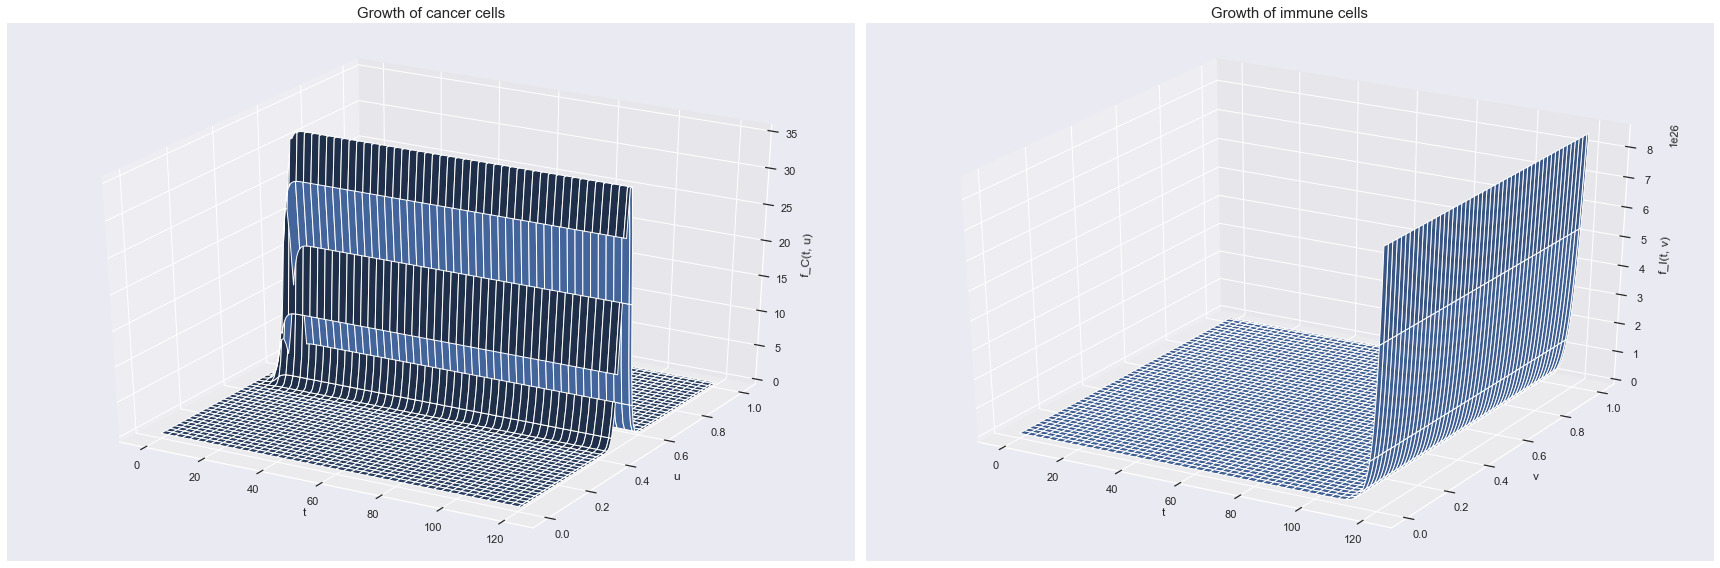

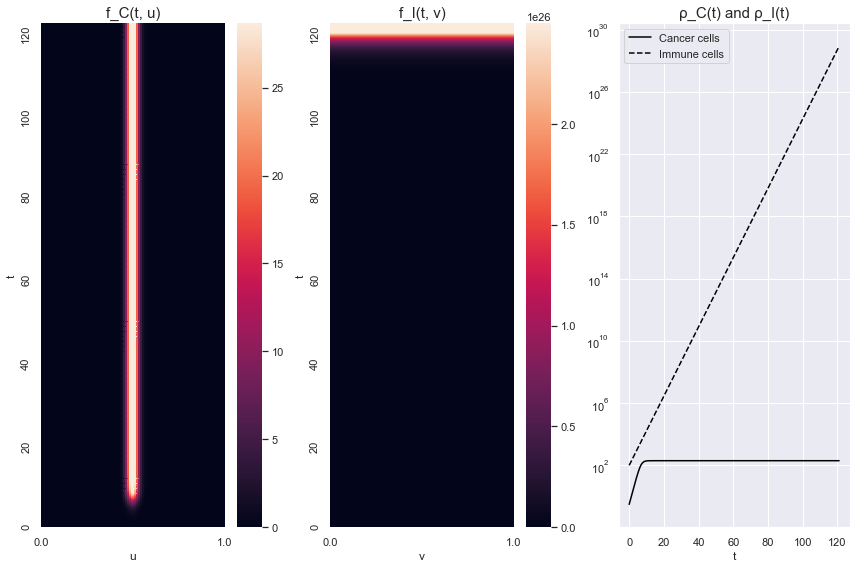

In [22]:
# cancer, immune, initial_values = simulate_growth(N=100)
plot_growth_surface(cancer, immune, initial_values)
plot_growth_cmap(cancer, immune, initial_values)

### Now setting $c_P(t) = C*\operatorname{sgn}(\sin(\omega*t)) \quad c_M(t) = 0$

where the paper defines $C \in \{4, 6, 8\}$ and $\omega = \frac{10*\pi}{T}\ (T\approx20)$

In [ ]:
C = 6
omega = np.pi/2
cancer, immune, initial_values = simulate_growth(c_P=lambda t: C*np.sign(np.sin(omega*t)))
plot_growth_surface(cancer, immune, initial_values)
plot_growth_cmap(cancer, immune, initial_values)

### Setting $c_P(t) = 0 \quad c_M(t) = C*\operatorname{sgn}(\sin(\omega*t))$

In [ ]:
cancer, immune, initial_values = simulate_growth(c_M=lambda t: C*np.sign(np.sin(omega*t)))
plot_growth_surface(cancer, immune, initial_values)
plot_growth_cmap(cancer, immune, initial_values)

### Setting both $c_P(t) = \frac{C}{2}*\operatorname{sgn}(\sin(\omega*t)) \quad c_M(t) = \frac{C}{2}*\operatorname{sgn}(\sin(\omega*t))$

In [ ]:
cancer, immune, initial_values = simulate_growth(c_P=lambda t: C/2*np.sign(np.sin(omega*t)),
                                                 c_M=lambda t: C/2*np.sign(np.sin(omega*t)))
plot_growth_surface(cancer, immune, initial_values)
plot_growth_cmap(cancer, immune, initial_values)